In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, brier_score_loss, confusion_matrix

DATA_PATH = "combined_cleaned.csv"

BATCH_SIZE = 512
LR = 1e-3
EPOCHS = 100
PATIENCE = 10

# CNN hyperparameters
HORIZON = 5          # future window for realized volatility
LOOKBACK = 10        # past days in temporal window
CHANNELS_1 = 64
CHANNELS_2 = 64
KERNEL_SIZE = 5
HIDDEN_DIM = 64
DROPOUT_CONV = 0.3
DROPOUT_DENSE = 0.4
HIGH_VOL_Q = 0.5

# Base features
BASE_FEATURES = ["log_return","lag1","lag3","lag5","MA5","MA20","vol_5","Volume","rel_vol","regime_high_vol"]

# Features inputted into the CNN
CANDIDATE_FEATURES = ["log_return","lag1","lag3","lag5","MA5","MA20","vol_5","Volume","rel_vol","regime_high_vol",# Base features
    "MA_diff","return_over_vol","volume_spike","log_return_z_cs","MA5_z_cs","MA20_z_cs","vol_5_z_cs","Volume_z_cs","rel_vol_z_cs","log_return_rank_cs","vol_5_rank_cs","Volume_rank_cs"] # Engineered features

# Candidate probability thresholds for converting CNN outputs into binary labels (0/1)
THRESHOLDS = [0.40, 0.45, 0.50, 0.55, 0.60]

# Parse dates, sort by (Ticker, Date), and drop invalid / duplicate rows
def load_and_basic_clean(path):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    df = df.dropna(subset=["Date"]).copy()
    df = df.sort_values(["Ticker", "Date"])
    df = df.drop_duplicates(subset=["Ticker", "Date"])
    return df

# Compute log_return based on that ticker’s Close series if not already done so
def ensure_log_return(df):
    df = df.copy()
    if "log_return" not in df.columns:
        df["log_return"] = (
            np.log(df["Close"]) - np.log(df.groupby("Ticker")["Close"].shift(1))
        )
    return df

# Add market regime classification based on the median of the market volatility
def add_market_regime(df, vol_window=20, min_periods=10):
    df = df.copy()
    mkt_ret = (
        df.groupby("Date")["log_return"]
          .mean()
          .sort_index()
    )
    mkt_vol = mkt_ret.rolling(window=vol_window, min_periods=min_periods).std()
    vol_median = mkt_vol.median()
    df["market_vol"] = df["Date"].map(mkt_vol)
    df["regime_high_vol"] = (df["market_vol"] > vol_median).astype(int)
    return df

# Compute realized volatility for the next 5 days
def add_realized_vol_5(df, horizon=5):
    """
    realized_vol_5(t) = sqrt( (r_{t+1}^2 + ... + r_{t+horizon}^2) / horizon )
    where r_t = log_return.
    """
    df = df.copy()
    df["realized_vol_5"] = np.nan
    for ticker, g in df.groupby("Ticker"):
        idx = g.index
        r = g["log_return"]
        r_sq = r ** 2
        acc = None
        for i in range(1, horizon + 1):
            shifted = r_sq.shift(-i)
            acc = shifted if acc is None else acc + shifted
        rv5 = np.sqrt(acc / horizon)
        df.loc[idx, "realized_vol_5"] = rv5
    return df

# Add engineered features (MA_diff, return_over_vol, and volume_spike) that help the CNN see trend, risk-adjusted moves, and unusual volume.
def add_interaction_features(df):
    df = df.copy()

    # MA_diff = MA5 - MA20
    if "MA5" in df.columns and "MA20" in df.columns:
        df["MA_diff"] = df["MA5"] - df["MA20"]

    # return_over_vol = log_return / (vol_5 + eps)
    if "log_return" in df.columns and "vol_5" in df.columns:
        eps = 1e-6
        df["return_over_vol"] = df["log_return"] / (df["vol_5"].replace(0, np.nan) + eps)

    # volume_spike = Volume today / 20-day rolling mean Volume (per ticker, window ending today)
    if "Volume" in df.columns:
        df["volume_spike"] = np.nan
        for ticker, g in df.groupby("Ticker"):
            idx = g.index
            vol = g["Volume"]
            vol_ma20 = vol.rolling(window=20, min_periods=5).mean()  # past 20 days
            df.loc[idx, "volume_spike"] = vol / (vol_ma20.replace(0, np.nan))

    return df

# Add cross-sectional z-scores and ranks to help the CNN see how each feature compares to others on the same day.
def add_cross_sectional_features(df):
    df = df.copy()

    cs_cols_for_z = ["log_return","MA5","MA20","vol_5","Volume","rel_vol"]

    # Add z-scores for each feature
    for col in cs_cols_for_z:
        if col not in df.columns:
            continue
        group = df.groupby("Date")[col]
        mean = group.transform("mean")
        std = group.transform("std").replace(0, np.nan)
        z_name = f"{col}_z_cs"
        df[z_name] = (df[col] - mean) / std
        df[z_name] = df[z_name].fillna(0.0)  # default to 0 if no std

    # Add rank-based features (0-1, within each date)
    rank_cols = ["log_return", "vol_5", "Volume"]
    for col in rank_cols:
        if col not in df.columns:
            continue
        r_name = f"{col}_rank_cs"
        df[r_name] = (
            df.groupby("Date")[col]
              .rank(pct=True)
        )

    return df

# Get the features that are actually in the dataframe
def get_feature_columns(df):
    feature_cols = [c for c in CANDIDATE_FEATURES if c in df.columns]
    if not feature_cols:
        raise ValueError("No candidate features found in dataframe.")
    df = df.dropna(subset=feature_cols).copy()
    feature_cols = [c for c in feature_cols if c in df.columns]
    return df, feature_cols

# Define the folds for the cross-validation
def define_folds():
    folds = [
        {
            "name": "fold1",
            "train_start": "2009-01-01",
            "train_end":   "2013-12-31",
            "val_start":   "2014-01-01",
            "val_end":     "2014-12-31",
            "test_start":  "2015-01-01",
            "test_end":    "2015-12-31",
        },
        {
            "name": "fold2",
            "train_start": "2009-01-01",
            "train_end":   "2014-12-31",
            "val_start":   "2015-01-01",
            "val_end":     "2015-12-31",
            "test_start":  "2016-01-01",
            "test_end":    "2016-12-31",
        },
        {
            "name": "fold3",
            "train_start": "2009-01-01",
            "train_end":   "2015-12-31",
            "val_start":   "2016-01-01",
            "val_end":     "2016-12-31",
            "test_start":  "2017-01-01",
            "test_end":    "2017-12-31",
        },
    ]
    for f in folds:
        for k in ["train_start","train_end","val_start","val_end","test_start","test_end"]:
            f[k] = pd.to_datetime(f[k])
    return folds

# Build sequences: X (N, LOOKBACK, d), rv5 (N,), dates (N,) (N is the number of samples, L is the lookback window, d is the number of features)
def build_sequences(df, feature_cols, lookback):
    X_list, rv_list, date_list, ticker_list = [], [], [], []
    for ticker, g in df.groupby("Ticker"):
        g = g.sort_values("Date")
        feats = g[feature_cols].values
        rv5 = g["realized_vol_5"].values
        dates = g["Date"].values
        tickers = g["Ticker"].values

        if len(g) < lookback:
            continue

        for i in range(lookback - 1, len(g)):
            if np.isnan(rv5[i]):
                continue  # need full future 5 days
            X_list.append(feats[i - lookback + 1:i + 1, :])
            rv_list.append(rv5[i])
            date_list.append(dates[i])
            ticker_list.append(tickers[i])

    X = np.array(X_list)          # (N, L, d)
    rv = np.array(rv_list)        # (N,)
    dates = np.array(date_list)   # (N,)
    tickers = np.array(ticker_list)
    return X, rv, dates, tickers


# Build the temporal CNN model
def build_temporal_cnn_single(lookback, n_features):
    inp = tf.keras.Input(shape=(lookback, n_features))
    x = tf.keras.layers.Conv1D(filters=CHANNELS_1, kernel_size=KERNEL_SIZE, activation="relu", padding="same")(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(DROPOUT_CONV)(x)
    x = tf.keras.layers.Conv1D(filters=CHANNELS_2, kernel_size=KERNEL_SIZE, activation="relu", padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(DROPOUT_CONV)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(HIDDEN_DIM, activation="relu")(x)
    x = tf.keras.layers.Dropout(DROPOUT_DENSE)(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss="binary_crossentropy",
    )
    return model

def evaluate_metrics(y_true, y_pred, p_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    try:
        roc_auc = roc_auc_score(y_true, p_pred)
    except ValueError:
        roc_auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, p_pred)
    except ValueError:
        pr_auc = np.nan
    brier = brier_score_loss(y_true, p_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "brier": brier,
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
    }


# Tune the threshold for the binary classification
def tune_threshold(y_val, p_val, thresholds):
    best_tau = 0.5
    best_acc = -1.0
    for tau in thresholds:
        preds = (p_val >= tau).astype(int)
        acc = accuracy_score(y_val, preds)
        if acc > best_acc:
            best_acc = acc
            best_tau = tau
    return best_tau

# Train one fold of the high-vol regime
def train_one_fold_highvol(X, rv5, dates, tickers, feature_cols, fold):
    train_mask = (dates >= fold["train_start"]) & (dates <= fold["train_end"])
    val_mask   = (dates >= fold["val_start"])   & (dates <= fold["val_end"])
    test_mask  = (dates >= fold["test_start"])  & (dates <= fold["test_end"])

    X_train, rv_train = X[train_mask], rv5[train_mask]
    X_val,   rv_val   = X[val_mask],   rv5[val_mask]
    X_test,  rv_test  = X[test_mask],  rv5[test_mask]

    dates_test   = dates[test_mask]
    tickers_test = tickers[test_mask]

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"[{fold['name']}] skipped (empty split)")
        return None, None

    # Define high-vol threshold from train realized_vol_5 only (no leakage)
    thr = np.quantile(rv_train, HIGH_VOL_Q)
    y_train = (rv_train >= thr).astype(int)
    y_val   = (rv_val   >= thr).astype(int)
    y_test  = (rv_test  >= thr).astype(int)

    # Baseline: majority class
    pos_ratio_train = y_train.mean()
    majority_label = 1 if pos_ratio_train >= 0.5 else 0
    baseline_acc_test = (y_test == majority_label).mean()

    # Scale features per fold
    N_train, L, d = X_train.shape
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(N_train * L, d)
    scaler.fit(X_train_flat)

    def transform(X_in):
        N, L, d = X_in.shape
        X_flat = X_in.reshape(N * L, d)
        X_scaled = scaler.transform(X_flat)
        return X_scaled.reshape(N, L, d)

    X_train_scaled = transform(X_train)
    X_val_scaled   = transform(X_val)
    X_test_scaled  = transform(X_test)

    train_ds = tf.data.Dataset.from_tensor_slices(
        (X_train_scaled, y_train.astype("float32"))
    ).shuffle(buffer_size=X_train_scaled.shape[0]).batch(BATCH_SIZE)

    val_ds = tf.data.Dataset.from_tensor_slices(
        (X_val_scaled, y_val.astype("float32"))
    ).batch(BATCH_SIZE)

    model = build_temporal_cnn_single(LOOKBACK, len(feature_cols))

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=PATIENCE, restore_best_weights=True
    )

    print(f"\n===== Training {fold['name']} for 5-day high-vol regime (temporal CNN) =====")
    model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[es], verbose=1)

    val_ds  = tf.data.Dataset.from_tensor_slices((X_val_scaled,  y_val.astype("float32"))).batch(BATCH_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test.astype("float32"))).batch(BATCH_SIZE)

    p_val  = model.predict(val_ds).ravel()
    p_test = model.predict(test_ds).ravel()

    best_tau = tune_threshold(y_val, p_val, THRESHOLDS)

    y_pred_test = (p_test >= best_tau).astype(int)
    acc_test = accuracy_score(y_test, y_pred_test)

    metrics = evaluate_metrics(y_test, y_pred_test, p_test)

    result = {
        "fold": fold["name"],
        "accuracy": acc_test,
        "baseline_acc": baseline_acc_test,
        "threshold": best_tau,
        "pos_ratio_train": float(pos_ratio_train),
        "n_train": int(X_train.shape[0]),
        "n_test": int(X_test.shape[0]),
    }
    result.update(metrics)

    fold_df = pd.DataFrame({
        "fold": fold["name"],
        "Date": dates_test,
        "Ticker": tickers_test,
        "realized_vol_5": rv_test,
        "high_vol_label": y_test,
        "p_high_vol_cnn": p_test,
    })
    return result, fold_df

# Pipeline for CNN
def run_highvol_cnn():
    df = load_and_basic_clean(DATA_PATH)
    df = ensure_log_return(df)
    df = add_market_regime(df)
    df = add_realized_vol_5(df, horizon=HORIZON)

    # Add engineered features
    df = add_interaction_features(df)
    df = add_cross_sectional_features(df)

    # Drop rows without realized_vol_5
    df = df.dropna(subset=["realized_vol_5"]).copy()

    df, feature_cols = get_feature_columns(df)

    X, rv5, dates, tickers = build_sequences(df, feature_cols, LOOKBACK)
    print(f"Sequences built: {X.shape[0]} samples, lookback={LOOKBACK}, features={X.shape[2]}")

    folds = define_folds()
    all_results = []
    all_fold_dfs = []  # NEW: for CSV

    for fold in folds:
        res, fold_df = train_one_fold_highvol(X, rv5, dates, tickers, feature_cols, fold)
        if res is not None:
            all_results.append(res)
        if fold_df is not None:
            all_fold_dfs.append(fold_df)

    results_df = pd.DataFrame(all_results)

    print("\n Per-fold test accuracy for 5-day high-vol regime (CNN)")
    print(results_df[["fold", "accuracy", "baseline_acc", "threshold", "pos_ratio_train", "n_train", "n_test"]])
    print("\n Additional per-fold metrics")
    print(results_df[["fold", "precision", "recall", "f1", "roc_auc", "pr_auc", "brier", "tn", "fp", "fn", "tp"]])
    print("\n Average test accuracy and baseline across folds")
    print("CNN accuracy (mean):", results_df["accuracy"].mean())
    print("Baseline accuracy (mean):", results_df["baseline_acc"].mean())
    print("F1 (mean):", results_df["f1"].mean())
    print("ROC-AUC (mean):", results_df["roc_auc"].mean())
    print("PR-AUC (mean):", results_df["pr_auc"].mean())
    print("Brier (mean):", results_df["brier"].mean())

    if all_fold_dfs:
        cnn_vol_outputs = pd.concat(all_fold_dfs, ignore_index=True)
        cnn_vol_outputs.to_csv("cnn_vol_outputs.csv", index=False)
        print("\nSaved per-sample volatility outputs to cnn_vol_outputs.csv")

    return results_df
    
results_df = run_highvol_cnn()

Sequences built: 27379 samples, lookback=10, features=22

===== Training fold1 for 5-day high-vol regime (temporal CNN) =====
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.9125 - val_loss: 0.7469
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.7402 - val_loss: 0.6405
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6990 - val_loss: 0.6206
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6531 - val_loss: 0.6096
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6318 - val_loss: 0.6016
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6183 - val_loss: 0.5991
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5964 - val_loss: 0.5971
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6005 - val_loss: 0.5917
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5837 - val_loss: 0.5922
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5848 - val_loss: 0.5915
Epoch 11/100


    fold  accuracy  baseline_acc  threshold  pos_ratio_train  n_train  n_test  \
0  fold1  0.657407      0.423280       0.50              0.5     5884    1512   
1  fold2  0.740741      0.361772       0.50              0.5     7306    1512   
2  fold3  0.856132      0.235849       0.45              0.5     8818    1272   

   precision    recall        f1   roc_auc    pr_auc     brier   tn  fp   fn  \
0   0.769912  0.271875  0.401848  0.632408  0.611580  0.259147  820  52  466   
1   0.783883  0.391225  0.521951  0.774984  0.692423  0.183133  906  59  333   
2   0.767123  0.560000  0.647399  0.753392  0.605839  0.166178  921  51  132   

    tp  
0  174  
1  214  
2  168  


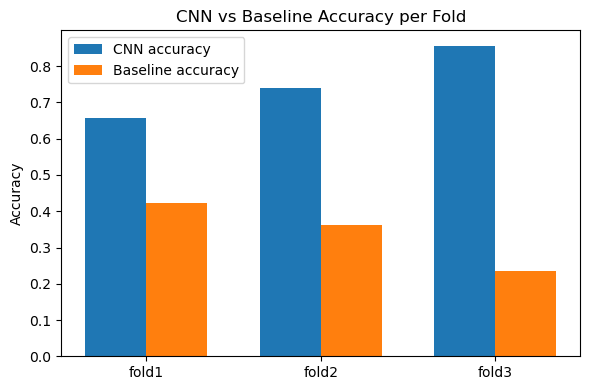

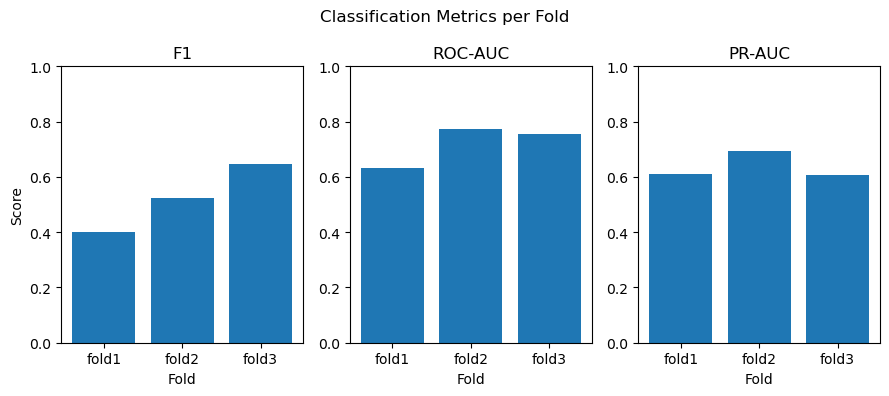

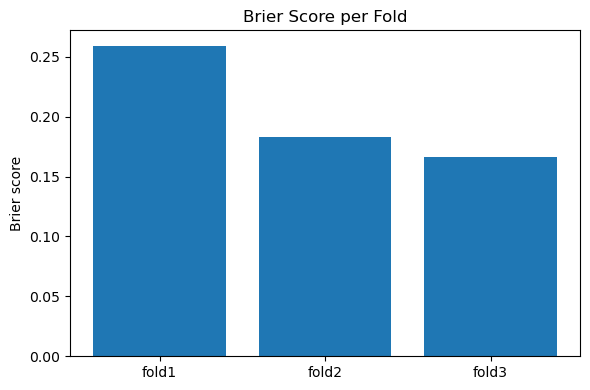

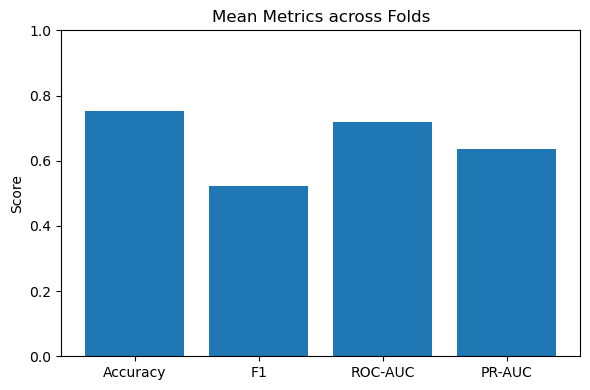

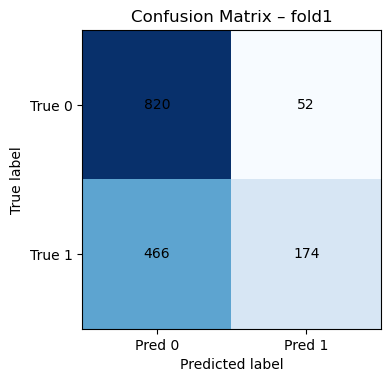

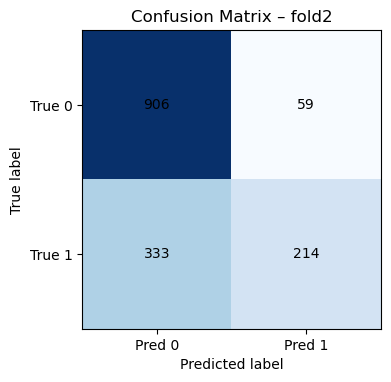

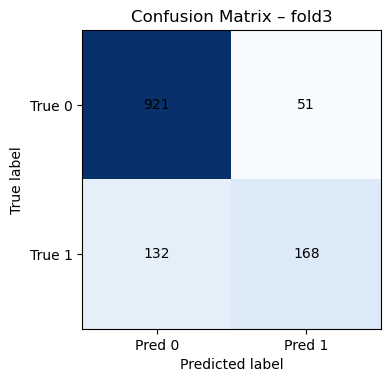

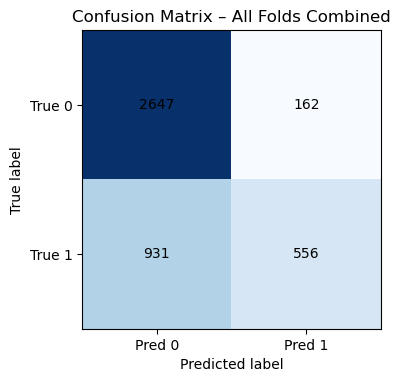

In [10]:
import numpy as np
import matplotlib.pyplot as plt

print(results_df)

folds = results_df["fold"].values
x = np.arange(len(folds))

# CNN vs Baseline Accuracy per fold
acc = results_df["accuracy"].values
baseline = results_df["baseline_acc"].values

plt.figure(figsize=(6, 4))
width = 0.35
plt.bar(x - width/2, acc, width, label="CNN accuracy")
plt.bar(x + width/2, baseline, width, label="Baseline accuracy")
plt.xticks(x, folds)
plt.ylabel("Accuracy")
plt.title("CNN vs Baseline Accuracy per Fold")
plt.legend()
plt.tight_layout()
plt.show()

# F1 / ROC-AUC / PR-AUC per fold
metrics = ["f1", "roc_auc", "pr_auc"]
metric_labels = ["F1", "ROC-AUC", "PR-AUC"]

plt.figure(figsize=(9, 4))
for i, m in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(folds, results_df[m].values)
    plt.ylim(0, 1)
    plt.title(metric_labels[i])
    plt.xlabel("Fold")
    if i == 0:
        plt.ylabel("Score")
plt.suptitle("Classification Metrics per Fold")
plt.tight_layout()
plt.show()

# Brier score per fold
plt.figure(figsize=(6, 4))
plt.bar(folds, results_df["brier"].values)
plt.ylabel("Brier score")
plt.title("Brier Score per Fold")
plt.tight_layout()
plt.show()

# Mean metrics across folds
mean_vals = {
    "Accuracy": results_df["accuracy"].mean(),
    "F1": results_df["f1"].mean(),
    "ROC-AUC": results_df["roc_auc"].mean(),
    "PR-AUC": results_df["pr_auc"].mean(),
}

plt.figure(figsize=(6, 4))
plt.bar(list(mean_vals.keys()), list(mean_vals.values()))
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Mean Metrics across Folds")
plt.tight_layout()
plt.show()

# Confusion matrices
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    for i in range(2):
        for j in range(2):
            ax.text(j, i, int(cm[i, j]),
                    ha="center", va="center")

    plt.tight_layout()
    plt.show()

# Per-fold confusion matrices
for _, row in results_df.iterrows():
    tn = row["tn"]
    fp = row["fp"]
    fn = row["fn"]
    tp = row["tp"]
    cm = np.array([[tn, fp],
                   [fn, tp]])
    plot_confusion_matrix(cm, title=f"Confusion Matrix – {row['fold']}")

# Aggregated confusion matrix across folds
tn_total = results_df["tn"].sum()
fp_total = results_df["fp"].sum()
fn_total = results_df["fn"].sum()
tp_total = results_df["tp"].sum()

cm_total = np.array([[tn_total, fp_total],
                     [fn_total, tp_total]])

plot_confusion_matrix(cm_total, title="Confusion Matrix – All Folds Combined")


In [19]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix
)

# =========================
# Paths & Hyperparameters
# =========================

DATA_PATH = "combined_cleaned.csv"
CNN_OUTPUT_PATH = "cnn_vol_outputs.csv"  # <-- CNN outputs (already generated)

LOOKBACK = 1
HIGH_VOL_Q = 0.5
THRESHOLDS = [0.40, 0.45, 0.50, 0.55, 0.60]

# Regime thresholds based on HIGH-VOL PROBABILITIES
# For SVM-only regimes and for the joint regimes with CNN
REGIME_THRESHOLDS = (0.40, 0.60)

BASE_FEATURES = [
    "log_return", "lag1", "lag3", "lag5",
    "MA5", "MA20", "vol_5", "Volume", "rel_vol", "regime_high_vol"
]

CANDIDATE_FEATURES = [
    "log_return", "lag1", "lag3", "lag5",
    "MA5", "MA20", "vol_5", "Volume", "rel_vol", "regime_high_vol",
    "MA_diff", "return_over_vol", "volume_spike",
    "log_return_z_cs", "MA5_z_cs", "MA20_z_cs",
    "vol_5_z_cs", "Volume_z_cs", "rel_vol_z_cs",
    "log_return_rank_cs", "vol_5_rank_cs", "Volume_rank_cs"
]

SVM_C_LINEAR = 1.0
SVM_C_RBF = 1.0
SVM_GAMMA_RBF = 0.01


# =========================
# Data preparation helpers
# =========================

def load_and_basic_clean(path):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    df = df.dropna(subset=["Date"]).copy()
    df = df.sort_values(["Ticker", "Date"])
    df = df.drop_duplicates(subset=["Ticker", "Date"])
    return df


def ensure_log_return(df):
    df = df.copy()
    if "log_return" not in df.columns:
        df["log_return"] = (
            np.log(df["Close"]) - np.log(df.groupby("Ticker")["Close"].shift(1))
        )
    return df


def add_market_regime(df, vol_window=20, min_periods=10):
    df = df.copy()
    mkt_ret = (
        df.groupby("Date")["log_return"]
          .mean()
          .sort_index()
    )
    mkt_vol = mkt_ret.rolling(window=vol_window, min_periods=min_periods).std()
    vol_median = mkt_vol.median()
    df["market_vol"] = df["Date"].map(mkt_vol)
    df["regime_high_vol"] = (df["market_vol"] > vol_median).astype(int)
    return df


def add_realized_vol_5(df, horizon=5):
    df = df.copy()
    df["realized_vol_5"] = np.nan
    for ticker, g in df.groupby("Ticker"):
        idx = g.index
        r = g["log_return"]
        r_sq = r ** 2
        acc = None
        for i in range(1, horizon + 1):
            shifted = r_sq.shift(-i)
            acc = shifted if acc is None else acc + shifted
        rv5 = np.sqrt(acc / horizon)
        df.loc[idx, "realized_vol_5"] = rv5
    return df


def add_interaction_features(df):
    df = df.copy()
    if "MA5" in df.columns and "MA20" in df.columns:
        df["MA_diff"] = df["MA5"] - df["MA20"]
    if "log_return" in df.columns and "vol_5" in df.columns:
        eps = 1e-6
        df["return_over_vol"] = df["log_return"] / (df["vol_5"].replace(0, np.nan) + eps)
    if "Volume" in df.columns:
        df["volume_spike"] = np.nan
        for ticker, g in df.groupby("Ticker"):
            idx = g.index
            vol = g["Volume"]
            vol_ma20 = vol.rolling(window=20, min_periods=5).mean()
            df.loc[idx, "volume_spike"] = vol / (vol_ma20.replace(0, np.nan))
    return df


def add_cross_sectional_features(df):
    df = df.copy()
    cs_cols_for_z = ["log_return","MA5","MA20","vol_5","Volume","rel_vol"]
    for col in cs_cols_for_z:
        if col not in df.columns:
            continue
        group = df.groupby("Date")[col]
        mean = group.transform("mean")
        std = group.transform("std").replace(0, np.nan)
        z_name = f"{col}_z_cs"
        df[z_name] = (df[col] - mean) / std
        df[z_name] = df[z_name].fillna(0.0)
    rank_cols = ["log_return", "vol_5", "Volume"]
    for col in rank_cols:
        if col not in df.columns:
            continue
        r_name = f"{col}_rank_cs"
        df[r_name] = (
            df.groupby("Date")[col]
              .rank(pct=True)
        )
    return df


def get_feature_columns(df):
    feature_cols = [c for c in CANDIDATE_FEATURES if c in df.columns]
    if not feature_cols:
        raise ValueError("No candidate features found in dataframe.")
    df = df.dropna(subset=feature_cols).copy()
    feature_cols = [c for c in feature_cols if c in df.columns]
    return df, feature_cols


def define_folds():
    folds = [
        {
            "name": "fold1",
            "train_start": "2009-01-01",
            "train_end":   "2013-12-31",
            "val_start":   "2014-01-01",
            "val_end":     "2014-12-31",
            "test_start":  "2015-01-01",
            "test_end":    "2015-12-31",
        },
        {
            "name": "fold2",
            "train_start": "2009-01-01",
            "train_end":   "2014-12-31",
            "val_start":   "2015-01-01",
            "val_end":     "2015-12-31",
            "test_start":  "2016-01-01",
            "test_end":    "2016-12-31",
        },
        {
            "name": "fold3",
            "train_start": "2009-01-01",
            "train_end":   "2015-12-31",
            "val_start":   "2016-01-01",
            "val_end":     "2016-12-31",
            "test_start":  "2017-01-01",
            "test_end":    "2017-12-31",
        },
    ]
    for f in folds:
        for k in ["train_start","train_end","val_start","val_end","test_start","test_end"]:
            f[k] = pd.to_datetime(f[k])
    return folds


def build_single_day_data(df, feature_cols):
    """
    X: (N, d), rv5: (N,), dates: (N,), tickers: (N,)
    """
    df = df.sort_values(["Ticker", "Date"])
    X       = df[feature_cols].values
    rv      = df["realized_vol_5"].values
    dates   = df["Date"].values
    tickers = df["Ticker"].values
    valid_mask = ~np.isnan(rv)
    return X[valid_mask], rv[valid_mask], dates[valid_mask], tickers[valid_mask]


# =========================
# Metrics helpers
# =========================

def evaluate_metrics(y_true, y_pred, p_pred):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, p_pred)
    except ValueError:
        roc_auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, p_pred)
    except ValueError:
        pr_auc = np.nan
    brier = brier_score_loss(y_true, p_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "brier": brier,
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
    }


def tune_threshold(y_val, p_val, thresholds):
    best_tau = 0.5
    best_acc = -1.0
    for tau in thresholds:
        preds = (p_val >= tau).astype(int)
        acc = accuracy_score(y_val, preds)
        if acc > best_acc:
            best_acc = acc
            best_tau = tau
    return best_tau


# =========================
# Linear SVM (high-vol vs low-vol)
# =========================

def train_one_fold_linear_svm(X, rv5, dates, feature_cols, fold):
    train_mask = (dates >= fold["train_start"]) & (dates <= fold["train_end"])
    val_mask   = (dates >= fold["val_start"])   & (dates <= fold["val_end"])
    test_mask  = (dates >= fold["test_start"])  & (dates <= fold["test_end"])

    X_train, rv_train = X[train_mask], rv5[train_mask]
    X_val,   rv_val   = X[val_mask],   rv5[val_mask]
    X_test,  rv_test  = X[test_mask],  rv5[test_mask]

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        return None, None

    thr = np.quantile(rv_train, HIGH_VOL_Q)
    y_train = (rv_train >= thr).astype(int)
    y_val   = (rv_val   >= thr).astype(int)
    y_test  = (rv_test  >= thr).astype(int)

    majority_label = 1 if y_train.mean() >= 0.5 else 0
    baseline_acc_test = (y_test == majority_label).mean()
    
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(C=SVM_C_LINEAR, kernel='linear', probability=True, random_state=42))
    ])

    print(f"\n===== Training {fold['name']} (Linear SVM) =====")
    model.fit(X_train, y_train)

    svm_step = model.named_steps['svm']
    linear_weights = svm_step.coef_[0]
    sv_count = svm_step.n_support_.sum()
    
    p_val = model.predict_proba(X_val)[:, 1]
    p_test = model.predict_proba(X_test)[:, 1]

    best_tau = tune_threshold(y_val, p_val, THRESHOLDS)
    y_pred_test = (p_test >= best_tau).astype(int)
    
    metrics = evaluate_metrics(y_test, y_pred_test, p_test)
    
    result = {
        "fold": fold["name"],
        "accuracy": accuracy_score(y_test, y_pred_test),
        "baseline_acc": baseline_acc_test,
        "sv_count": int(sv_count),
        **metrics
    }
    
    weight_df = pd.DataFrame({'Feature': feature_cols, 'Weight': linear_weights})
    top_10_weights = weight_df.reindex(
        weight_df['Weight'].abs().sort_values(ascending=False).index
    ).head(10)
    
    return result, top_10_weights


# =========================
# RBF SVM + Regimes
# =========================

def train_one_fold_rbf_svm(X, rv5, dates, tickers, feature_cols, fold):
    train_mask = (dates >= fold["train_start"]) & (dates <= fold["train_end"])
    val_mask   = (dates >= fold["val_start"])   & (dates <= fold["val_end"])
    test_mask  = (dates >= fold["test_start"])  & (dates <= fold["test_end"])

    X_train, rv_train = X[train_mask], rv5[train_mask]
    X_val,   rv_val   = X[val_mask],   rv5[val_mask]
    X_test,  rv_test  = X[test_mask],  rv5[test_mask]

    dates_test   = dates[test_mask]
    tickers_test = tickers[test_mask]

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        return None, None

    thr = np.quantile(rv_train, HIGH_VOL_Q)
    y_train = (rv_train >= thr).astype(int)
    y_val   = (rv_val   >= thr).astype(int)
    y_test  = (rv_test  >= thr).astype(int)
    
    majority_label = 1 if y_train.mean() >= 0.5 else 0
    baseline_acc_test = (y_test == majority_label).mean()

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            C=SVM_C_RBF,
            kernel='rbf',
            gamma=SVM_GAMMA_RBF,
            probability=True,
            random_state=42
        ))
    ])

    print(f"\n===== Training {fold['name']} (RBF SVM - High-Vol classifier) =====")
    model.fit(X_train, y_train)

    p_val = model.predict_proba(X_val)[:, 1]
    p_test = model.predict_proba(X_test)[:, 1]
    
    sv_count = model.named_steps['svm'].n_support_.sum()
    
    best_tau = tune_threshold(y_val, p_val, THRESHOLDS)
    y_pred_test = (p_test >= best_tau).astype(int)
    
    metrics = evaluate_metrics(y_test, y_pred_test, p_test)
    
    result = {
        "fold": fold["name"],
        "accuracy": accuracy_score(y_test, y_pred_test),
        "baseline_acc": baseline_acc_test,
        "sv_count": int(sv_count),
        **metrics
    }

    # ===== Regime A/B/C based on SVM high-vol probability (SVM-only regimes) =====
    low_thr, high_thr = REGIME_THRESHOLDS

    regime_code_svm = np.full(p_test.shape, "A", dtype=object)
    mask_B = (p_test >= low_thr) & (p_test < high_thr)
    mask_C = p_test >= high_thr
    regime_code_svm[mask_B] = "B"
    regime_code_svm[mask_C] = "C"

    desc_map = {
        "A": "Normal regime – OK to be active, but still prudent",
        "B": "Elevated but not extreme vol – caution / smaller size",
        "C": "Extreme vol regime – risk-off / pull back",
    }
    regime_desc_svm = [desc_map[str(c)] for c in regime_code_svm]

    fold_regime_df = pd.DataFrame({
        "fold": fold["name"],
        "Date": dates_test,
        "Ticker": tickers_test,
        "realized_vol_5": rv_test,
        "p_high_vol_svm": p_test,
        "regime_code_svm": regime_code_svm,
        "regime_desc_svm": regime_desc_svm,
    })

    return result, fold_regime_df


# =========================
# Main pipeline + CNN merge
# =========================

def run_svm_comparison():
    df = load_and_basic_clean(DATA_PATH)
    df = ensure_log_return(df)
    df = add_market_regime(df)
    df = add_realized_vol_5(df, horizon=5)
    df = add_interaction_features(df)
    df = add_cross_sectional_features(df)
    df = df.dropna(subset=["realized_vol_5"]).copy()

    df, feature_cols = get_feature_columns(df)
    X, rv5, dates, tickers = build_single_day_data(df, feature_cols)
    print(f"Data built: {X.shape[0]} samples, features={X.shape[1]}")
    folds = define_folds()
    
    # ---------- Linear SVM ----------
    linear_results = []
    all_weights = {}

    for fold in folds:
        res, weights_df = train_one_fold_linear_svm(X, rv5, dates, feature_cols, fold)
        if res is not None:
            linear_results.append(res)
            all_weights[fold['name']] = weights_df
            
    linear_df = pd.DataFrame(linear_results)
    
    print("\n\n=============== LINEAR SVM RESULTS (Kernel: Linear) ===============")
    print("Interpretation: Measures linear separability and provides feature weights.")
    if not linear_df.empty:
        print("Per-fold Metrics:\n", linear_df[["fold", "accuracy", "roc_auc", "f1", "sv_count"]])
        print("\nAverage ROC-AUC (Linear):", linear_df["roc_auc"].mean())
        print("\nTop 10 Feature Weights (Fold 3 Example):")
        if 'fold3' in all_weights:
            print(all_weights['fold3'])
    else:
        print("No valid folds for linear SVM.")

    # ---------- RBF SVM + SVM-only regimes ----------
    rbf_results = []
    regime_dfs = []

    for fold in folds:
        res, fold_regime_df = train_one_fold_rbf_svm(
            X, rv5, dates, tickers, feature_cols, fold
        )
        if res is not None:
            rbf_results.append(res)
        if fold_regime_df is not None:
            regime_dfs.append(fold_regime_df)
            
    rbf_df = pd.DataFrame(rbf_results)
    
    print("\n\n=============== RBF SVM RESULTS (Kernel: RBF) ===============")
    print("Interpretation: Measures robustness to non-linear separation (Project Goal).")
    if not rbf_df.empty:
        print("Per-fold Metrics:\n", rbf_df[["fold", "accuracy", "roc_auc", "f1", "sv_count"]])
        print("\nAverage ROC-AUC (RBF):", rbf_df["roc_auc"].mean())
        print("\nAverage Performance Comparison:")
        comparison = {
            "Linear AUC": linear_df["roc_auc"].mean() if not linear_df.empty else np.nan,
            "RBF AUC": rbf_df["roc_auc"].mean(),
            "Linear SV Count Mean": linear_df["sv_count"].mean() if not linear_df.empty else np.nan,
            "RBF SV Count Mean": rbf_df["sv_count"].mean()
        }
        print(pd.Series(comparison))
    else:
        print("No valid folds for RBF SVM.")

    if regime_dfs:
        regimes_df = pd.concat(regime_dfs, ignore_index=True)
        print("\n\n=============== SVM-ONLY REGIME COUNTS (A/B/C from SVM prob) ===============")
        print("All folds SVM-only regime counts:")
        print(regimes_df["regime_code_svm"].value_counts().sort_index())
    else:
        regimes_df = pd.DataFrame()
        print("\nNo regime outputs were generated (no valid RBF folds).")
        return linear_df, rbf_df, regimes_df

    # ---------- Merge with CNN outputs & build JOINT regimes ----------
    try:
        cnn_df = pd.read_csv(CNN_OUTPUT_PATH)
        cnn_df["Date"] = pd.to_datetime(cnn_df["Date"])
        # Expect columns: fold, Date, Ticker, realized_vol_5, high_vol_label, p_high_vol_cnn
        cols_needed = ["fold", "Date", "Ticker", "p_high_vol_cnn"]
        cols_present = [c for c in cols_needed if c in cnn_df.columns]
        if len(cols_present) < 4:
            print("\nWARNING: cnn_vol_outputs.csv missing some expected columns, using what is available:", cols_present)
        merged = regimes_df.merge(
            cnn_df[["fold", "Date", "Ticker", "p_high_vol_cnn"]],
            on=["fold", "Date", "Ticker"],
            how="left"
        )
        # Build joint regime using both SVM prob and CNN prob (where available)
        low_thr, high_thr = REGIME_THRESHOLDS
        ps = merged["p_high_vol_svm"].values
        pc = merged["p_high_vol_cnn"].values  # may contain NaN

        # Start from SVM-only regime as default
        joint_code = merged["regime_code_svm"].astype(str).values

        mask_valid = ~np.isnan(pc)
        maskA = (ps < low_thr) & (pc < low_thr) & mask_valid
        maskC = (ps >= high_thr) & (pc >= high_thr) & mask_valid
        maskB = mask_valid & ~(maskA | maskC)

        joint_code[maskA] = "A"
        joint_code[maskC] = "C"
        joint_code[maskB] = "B"

        desc_map = {
            "A": "Normal regime – OK to be active, but still prudent",
            "B": "Elevated but not extreme vol – caution / smaller size",
            "C": "Extreme vol regime – risk-off / pull back",
        }
        joint_desc = [desc_map[c] for c in joint_code]

        merged["regime_code_joint"] = joint_code
        merged["regime_desc_joint"] = joint_desc

        regimes_df = merged

        print("\n\n=============== JOINT REGIME COUNTS (SVM + CNN) ===============")
        print("All folds JOINT regime counts:")
        print(regimes_df["regime_code_joint"].value_counts().sort_index())

        test_regimes = regimes_df[regimes_df["fold"] == "fold3"]
        print("\nFold3 (TEST) JOINT regime counts:")
        print(test_regimes["regime_code_joint"].value_counts().sort_index())

        # Optional: save to CSV for report
        regimes_df.to_csv("svm_cnn_joint_regimes.csv", index=False)
        print("\nSaved joint regimes to svm_cnn_joint_regimes.csv")

    except FileNotFoundError:
        print(f"\nWARNING: {CNN_OUTPUT_PATH} not found. Only SVM-only regimes are available.")
    except Exception as e:
        print("\nWARNING: Error while merging CNN outputs:", e)

    return linear_df, rbf_df, regimes_df


# Run
linear_df, rbf_df, regimes_df = run_svm_comparison()


Data built: 27433 samples, features=22

===== Training fold1 (Linear SVM) =====

===== Training fold2 (Linear SVM) =====

===== Training fold3 (Linear SVM) =====


=============== LINEAR SVM RESULTS (Kernel: Linear) ===============
Interpretation: Measures linear separability and provides feature weights.
Per-fold Metrics:
     fold  accuracy   roc_auc        f1  sv_count
0  fold1  0.608466  0.583078  0.293556      4309
1  fold2  0.761243  0.806475  0.601105      5467
2  fold3  0.836478  0.743827  0.610487      6753

Average ROC-AUC (Linear): 0.711126747908652

Top 10 Feature Weights (Fold 3 Example):
            Feature    Weight
15        MA20_z_cs -1.266372
16       vol_5_z_cs -1.095449
14         MA5_z_cs  0.568061
9   regime_high_vol  0.391614
7            Volume  0.336958
20    vol_5_rank_cs  0.253631
17      Volume_z_cs -0.187003
21   Volume_rank_cs -0.171590
12     volume_spike  0.163317
6             vol_5  0.122044

===== Training fold1 (RBF SVM - High-Vol classifier) =====



Results DataFrame used for plots:
    fold  accuracy  baseline_acc  sv_count  precision    recall        f1  \
0  fold1  0.675265      0.421296      4004   0.717262  0.378336  0.495375   
1  fold2  0.768519      0.361772      4980   0.714597  0.599634  0.652087   
2  fold3  0.852987      0.235849      6147   0.753363  0.560000  0.642447   

    roc_auc    pr_auc     brier   tn   fp   fn   tp  
0  0.670561  0.630453  0.238053  780   95  396  241  
1  0.800030  0.730050  0.170127  834  131  219  328  
2  0.806067  0.630732  0.149886  917   55  132  168  


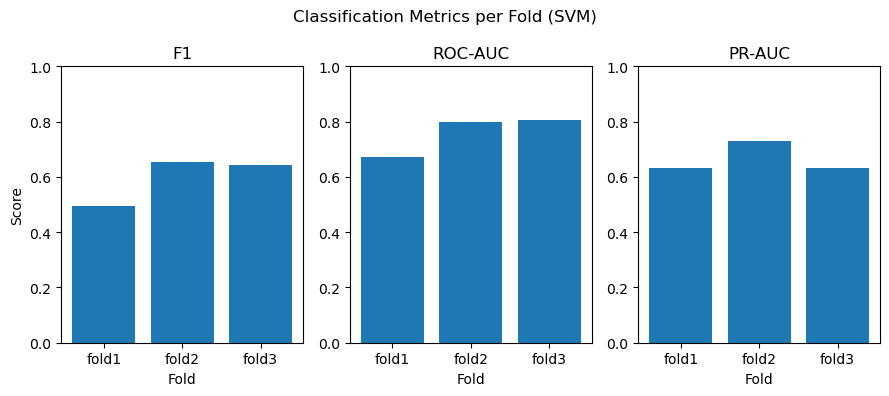

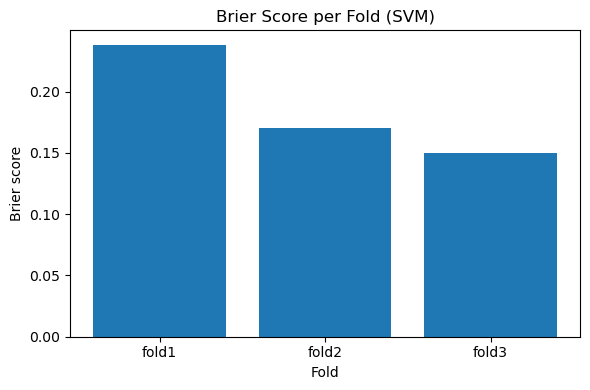

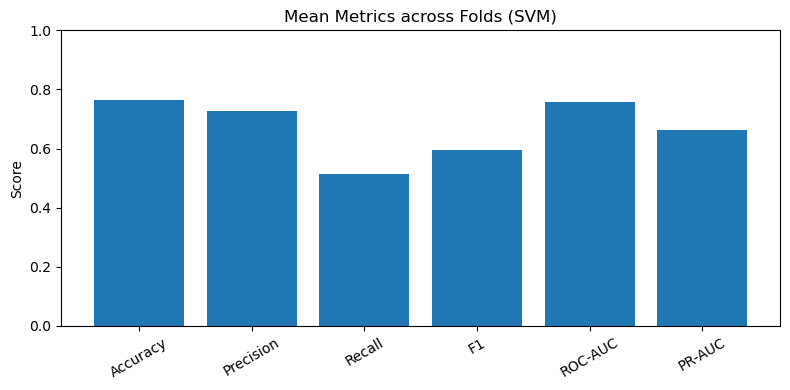


Mean metrics across folds:
Accuracy: 0.7656
Precision: 0.7284
Recall: 0.5127
F1: 0.5966
ROC-AUC: 0.7589
PR-AUC: 0.6637
Brier (mean): 0.1860


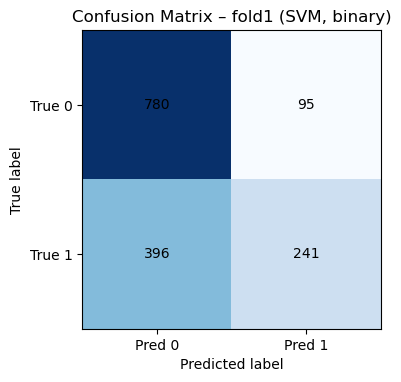

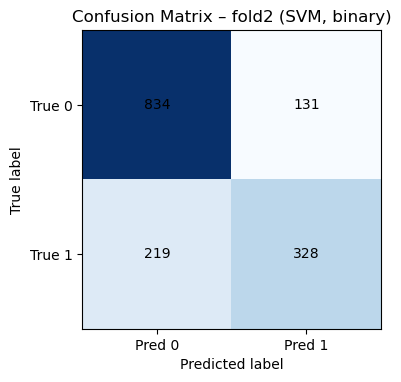

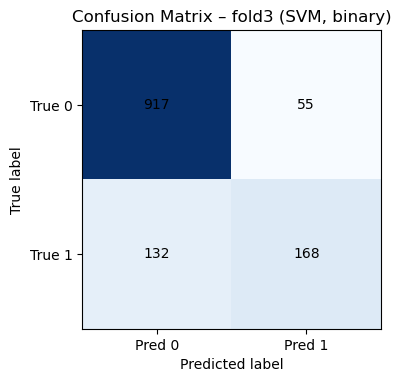


Aggregated confusion matrix across folds (binary):
[[2531  281]
 [ 747  737]]


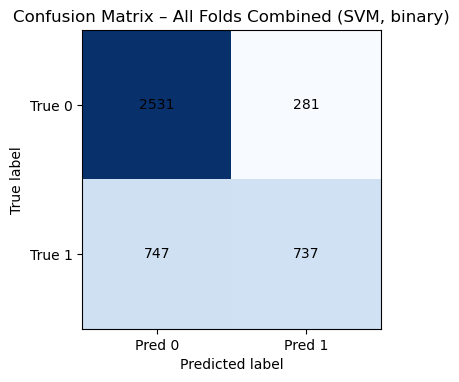


=== A/B/C Regime Confusion Matrices ===


KeyError: 'regime_true'

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix  # for A/B/C regimes

results_df = rbf_df.copy()

print("Results DataFrame used for plots:")
print(results_df)

folds = results_df["fold"].values
x = np.arange(len(folds))

# F1 / ROC-AUC / PR-AUC per fold
metrics = ["f1", "roc_auc", "pr_auc"]
metric_labels = ["F1", "ROC-AUC", "PR-AUC"]

plt.figure(figsize=(9, 4))
for i, m in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(folds, results_df[m].values)
    plt.ylim(0, 1)
    plt.title(metric_labels[i])
    plt.xlabel("Fold")
    if i == 0:
        plt.ylabel("Score")
plt.suptitle("Classification Metrics per Fold (SVM)")
plt.tight_layout()
plt.show()

# Brier score per fold
plt.figure(figsize=(6, 4))
plt.bar(folds, results_df["brier"].values)
plt.ylabel("Brier score")
plt.title("Brier Score per Fold (SVM)")
plt.xlabel("Fold")
plt.tight_layout()
plt.show()

# Mean metrics across folds
mean_vals = {
    "Accuracy": results_df["accuracy"].mean(),
    "Precision": results_df["precision"].mean(),
    "Recall": results_df["recall"].mean(),
    "F1": results_df["f1"].mean(),
    "ROC-AUC": results_df["roc_auc"].mean(),
    "PR-AUC": results_df["pr_auc"].mean(),
}

plt.figure(figsize=(8, 4))
plt.bar(list(mean_vals.keys()), list(mean_vals.values()))
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Mean Metrics across Folds (SVM)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print("\nMean metrics across folds:")
for k, v in mean_vals.items():
    print(f"{k}: {v:.4f}")
print(f"Brier (mean): {results_df['brier'].mean():.4f}")

# =========================
# Binary confusion matrices (high-vol classifier)
# =========================

def plot_confusion_matrix_binary(cm, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # Annotate counts
    for i in range(2):
        for j in range(2):
            ax.text(j, i, int(cm[i, j]),
                    ha="center", va="center")

    plt.tight_layout()
    plt.show()

# Per-fold confusion matrices (binary)
for _, row in results_df.iterrows():
    tn = row["tn"]
    fp = row["fp"]
    fn = row["fn"]
    tp = row["tp"]
    cm = np.array([[tn, fp],
                   [fn, tp]])
    plot_confusion_matrix_binary(cm, title=f"Confusion Matrix – {row['fold']} (SVM, binary)")

# Aggregated confusion matrix across folds (binary)
tn_total = results_df["tn"].sum()
fp_total = results_df["fp"].sum()
fn_total = results_df["fn"].sum()
tp_total = results_df["tp"].sum()

cm_total = np.array([[tn_total, fp_total],
                     [fn_total, tp_total]])

print("\nAggregated confusion matrix across folds (binary):")
print(cm_total)

plot_confusion_matrix_binary(cm_total, title="Confusion Matrix – All Folds Combined (SVM, binary)")

# =========================
# Multi-class confusion matrices for regimes A/B/C
# =========================

def plot_confusion_matrix_multi(cm, labels, title):
    """Generic multi-class confusion matrix plot."""
    num_classes = len(labels)
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels([f"Pred {l}" for l in labels])
    ax.set_yticklabels([f"True {l}" for l in labels])

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # Annotate counts
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, int(cm[i, j]),
                    ha="center", va="center")

    plt.tight_layout()
    plt.show()

# Only run A/B/C confusion if regimes_df exists in the current notebook
if "regimes_df" in globals():
    print("\n=== A/B/C Regime Confusion Matrices ===")

    # 1. Build TRUE regimes from realized_vol_5 using terciles (1/3, 2/3)
    low_rv_thr  = regimes_df["realized_vol_5"].quantile(1/3)
    high_rv_thr = regimes_df["realized_vol_5"].quantile(2/3)
    print(f"Realized vol thresholds for TRUE regimes: low={low_rv_thr:.6f}, high={high_rv_thr:.6f}")

    def realized_to_regime(rv):
        if rv < low_rv_thr:
            return "A"   # Normal regime
        elif rv < high_rv_thr:
            return "B"   # Elevated regime
        else:
            return "C"   # Extreme regime

    regimes_df = regimes_df.copy()
    regimes_df["regime_true"] = regimes_df["realized_vol_5"].apply(realized_to_regime)

    # 2. Treat regime_code_joint as regime_pred (fallback to regime_code_svm if needed)
    if "regime_code_joint" in regimes_df.columns:
        pred_col_name = "regime_code_joint"
    else:
        pred_col_name = "regime_code_svm"  # fallback

    regimes_df["regime_pred"] = regimes_df[pred_col_name].astype(str)

    labels = ["A", "B", "C"]

    # ---- Overall 3×3 confusion matrix across all folds ----
    cm_regime_total = confusion_matrix(
        regimes_df["regime_true"],
        regimes_df["regime_pred"],
        labels=labels
    )

    print("\nAggregated A/B/C confusion matrix across folds:")
    print("Rows = true regime, Columns = predicted regime")
    print(cm_regime_total)

    # Print “TP” per class (diagonal)
    for i, l in enumerate(labels):
        print(f"TP for class {l} (true {l}, predicted {l}): {cm_regime_total[i, i]}")

    plot_confusion_matrix_multi(
        cm_regime_total,
        labels,
        title=f"Confusion Matrix – All Folds Combined (Regimes A/B/C, pred={pred_col_name})"
    )

    # ---- Per-fold 3×3 confusion matrices ----
    if "fold" in regimes_df.columns:
        for fold_name, g in regimes_df.groupby("fold"):
            cm_fold = confusion_matrix(
                g["regime_true"],
                g["regime_pred"],
                labels=labels
            )
            print(f"\nA/B/C confusion matrix for {fold_name}:")
            print("Rows = true regime, Columns = predicted regime")
            print(cm_fold)

            plot_confusion_matrix_multi(
                cm_fold,
                labels,
                title=f"Confusion Matrix – {fold_name} (Regimes A/B/C, pred={pred_col_name})"
            )
    else:
        print("\nError.")
else:
    print("\nError.")
